# Import Library 
Each pipeline consists of a certain sequence of calibration steps and is defined as a python class within a python code module. From within python, the pipelines are called by their class names, but configuration files can still be supplied in order to set pipeline or step parameter values

In [1]:
import os
#os.environ['CRDS_PATH'] = '/fenrirdata1/kg_data/crds_cache/' #These are already defined in my ~./bash profile now
#os.environ['CRDS_SERVER_URL']= 'https://jwst-crds.stsci.edu'
os.environ['CRDS_CONTEXT']='jwst_0756.pmap'

import jwst
print(jwst.__version__)

from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from jwst.pipeline.calwebb_image2 import Image2Pipeline
from jwst.pipeline.calwebb_tso3 import Tso3Pipeline
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase

from astropy.io import fits, ascii
import matplotlib.pyplot as plt
import csv
import numpy as np
import ref_pixels
from splintegrate import splintegrate
import asdf
import astropy.units as u

1.3.1


# Stage 1
### Detector-level corrections and ramp fitting for individual exposures.
Stage 1 consists of detector-level corrections that are performed on a group-by-group basis, followed by ramp fitting. The output of stage 1 processing is a countrate image per exposure, or per integration for some modes.

#### Detector1Pipeline: 
Apply all calibration steps to raw JWST ramps to produce a 2-D slope product. This stage takes care of basic data reduction steps, such as reference pixel correction, superbias subtraction, removal of non-linearity, and flagging of cosmic rays. In the final step in this stage of the pipeline, line-fitting is performed on each integration. A slope image is created for each integration. The steps in this stage are identical for all data.

In [20]:
#adding a header input for the number of output amplifiers. 
HDUList = fits.open('/fenrirdata1/es_tso/sim_data/mirage_027_super_short_grism256/sim_data/jw88888001001_01101_00001_nrca1_uncal.fits')
HDUList[0].header['NOUTPUTS'] = (4, 'number of output amplifiers')

HDUList.writeto('modified_jw88888001001_01101_00001_nrca1_uncal.fits', overwrite=True) #already exists for me. Run this line if you do not have this file. 
HDUList[0].header

[py.warnings:WARNING] /tmp/ipykernel_4159815/792314660.py:2: ResourceWarning: unclosed file <_io.FileIO name='/fenrirdata1/es_tso/sim_data/mirage_027_super_short_grism256/sim_data/jw88888001001_01101_00001_nrca1_uncal.fits' mode='rb' closefd=True>
  HDUList = fits.open('/fenrirdata1/es_tso/sim_data/mirage_027_super_short_grism256/sim_data/jw88888001001_01101_00001_nrca1_uncal.fits')



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2021-09-10T18:31:49.177' / UTC date file created                     
ORIGIN  = 'STScI   '           / Organization responsible for creating file     
FILENAME= 'jw88888001001_01101_00001_nrca1_uncal.fits' / Name of the file       
FILETYPE= 'raw     '           / Type of data in the file                       
DATAMODL= 'RampModel'          / Type of data model                             
TELESCOP= 'JWST    '           / Telescope used to acquire the data             
                                                                                
        Program information                                                     
                            

In [3]:
filename_stage1='modified_jw88888001001_01101_00001_nrca1_uncal.fits' #Use the modified uncalibrated file created above

# Instantiate the class. Do not provide a configuration file.
pipeline_stage1 = Detector1Pipeline()

# Manually set any desired non-default parameter values

# Default is to skip the persistence and IPC correction
# Make that explicit here
pipeline_stage1.persistence.skip = True
pipeline_stage1.ipc.skip = True

pipeline_stage1.refpix.skip = False #Make sure to skip steps appropriate if using an alternate ref pix correction method
pipeline_stage1.superbias.skip = False 

# The default value for CR flagging is 3 or 4 sigma
# which tends to be too aggressive and flags noise.
# Set it to something more reasonable
pipeline_stage1.jump.rejection_threshold = 9

# Specify that you want results saved to a file
pipeline_stage1.save_results = True
pipeline_stage1.output_dir = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/'

# Execute the pipeline using the run method
result_stage1 = pipeline_stage1.run(filename_stage1)

2021-09-13 02:27:33,475 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


[stpipe.Detector1Pipeline:INFO] Detector1Pipeline instance created.


2021-09-13 02:27:33,479 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


[stpipe.Detector1Pipeline.group_scale:INFO] GroupScaleStep instance created.


2021-09-13 02:27:33,485 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


[stpipe.Detector1Pipeline.dq_init:INFO] DQInitStep instance created.


2021-09-13 02:27:33,490 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


[stpipe.Detector1Pipeline.saturation:INFO] SaturationStep instance created.


2021-09-13 02:27:33,493 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


[stpipe.Detector1Pipeline.ipc:INFO] IPCStep instance created.


2021-09-13 02:27:33,497 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


[stpipe.Detector1Pipeline.superbias:INFO] SuperBiasStep instance created.


2021-09-13 02:27:33,502 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


[stpipe.Detector1Pipeline.refpix:INFO] RefPixStep instance created.


2021-09-13 02:27:33,511 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


[stpipe.Detector1Pipeline.rscd:INFO] RscdStep instance created.


2021-09-13 02:27:33,517 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


[stpipe.Detector1Pipeline.firstframe:INFO] FirstFrameStep instance created.


2021-09-13 02:27:33,522 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


[stpipe.Detector1Pipeline.lastframe:INFO] LastFrameStep instance created.


2021-09-13 02:27:33,528 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


[stpipe.Detector1Pipeline.linearity:INFO] LinearityStep instance created.


2021-09-13 02:27:33,533 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


[stpipe.Detector1Pipeline.dark_current:INFO] DarkCurrentStep instance created.


2021-09-13 02:27:33,539 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


[stpipe.Detector1Pipeline.reset:INFO] ResetStep instance created.


2021-09-13 02:27:33,545 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


[stpipe.Detector1Pipeline.persistence:INFO] PersistenceStep instance created.


2021-09-13 02:27:33,552 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


[stpipe.Detector1Pipeline.jump:INFO] JumpStep instance created.


2021-09-13 02:27:33,558 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


[stpipe.Detector1Pipeline.ramp_fit:INFO] RampFitStep instance created.


2021-09-13 02:27:33,564 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


[stpipe.Detector1Pipeline.gain_scale:INFO] GainScaleStep instance created.


2021-09-13 02:27:33,674 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('modified_jw88888001001_01101_00001_nrca1_uncal.fits',).


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline running with args ('modified_jw88888001001_01101_00001_nrca1_uncal.fits',).


2021-09-13 02:27:33,699 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'

[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks'

2021-09-13 02:27:34,730 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']


[stpipe.Detector1Pipeline:INFO] Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias']
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:36,231 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0213.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for DARK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0213.fits'.


2021-09-13 02:27:36,235 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0050.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0050.fits'.


2021-09-13 02:27:36,238 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for LINEARITY reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits'.


2021-09-13 02:27:36,241 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0044.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for MASK reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0044.fits'.


2021-09-13 02:27:36,243 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0025.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0025.fits'.


2021-09-13 02:27:36,246 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for REFPIX reference file is 'N/A'.


2021-09-13 02:27:36,248 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RESET reference file is 'N/A'.


2021-09-13 02:27:36,250 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


[stpipe.Detector1Pipeline:INFO] Prefetch for RSCD reference file is 'N/A'.


2021-09-13 02:27:36,252 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0064.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SATURATION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0064.fits'.


2021-09-13 02:27:36,258 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0026.fits'.


[stpipe.Detector1Pipeline:INFO] Prefetch for SUPERBIAS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0026.fits'.
[      root:INFO] Starting calwebb_detector1 ...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[      root:DEBUG] Processing a Near-IR exposure


2021-09-13 02:27:36,683 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:36,687 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:36,826 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


[stpipe.Detector1Pipeline.group_scale:INFO] NFRAMES=1 is a power of 2; correction not needed


2021-09-13 02:27:36,828 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.group_scale:INFO] Step will be skipped


2021-09-13 02:27:36,833 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


[stpipe.Detector1Pipeline.group_scale:INFO] Step group_scale done


2021-09-13 02:27:36,951 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:36,955 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:37,008 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0044.fits


[stpipe.Detector1Pipeline.dq_init:INFO] Using MASK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_mask_0044.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=1, subsize2=256
[jwst.dq_init.dq_initialization:INFO] Extracting mask subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xs

2021-09-13 02:27:38,847 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


[stpipe.Detector1Pipeline.dq_init:INFO] Step dq_init done


2021-09-13 02:27:38,953 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:38,957 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:39,007 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0064.fits


[stpipe.Detector1Pipeline.saturation:INFO] Using SATURATION reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0064.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NO_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword FEW_SAMPLES does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword AD_SATURATION does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword WEIRD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword DEAD_PIXEL does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=1, subsize2=256
[jwst.saturation.saturation:INFO] Extracting reference file subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=0, ystop=256
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.saturation.saturation:INFO] Detected 10269 saturated pixels
[jwst.saturation.saturation:INFO] Detected 3 A/D floor pixels


2021-09-13 02:27:39,768 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


[stpipe.Detector1Pipeline.saturation:INFO] Step saturation done


2021-09-13 02:27:39,869 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:39,873 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2021-09-13 02:27:39,875 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


[stpipe.Detector1Pipeline.ipc:INFO] Step skipped.


2021-09-13 02:27:39,880 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


[stpipe.Detector1Pipeline.ipc:INFO] Step ipc done


2021-09-13 02:27:39,980 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:39,984 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:40,037 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0026.fits


[stpipe.Detector1Pipeline.superbias:INFO] Using SUPERBIAS reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0026.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=1, subsize2=256
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=0, ystop=256
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:40,723 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


[stpipe.Detector1Pipeline.superbias:INFO] Step superbias done


2021-09-13 02:27:40,832 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:40,836 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:40,863 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True


[stpipe.Detector1Pipeline.refpix:INFO] use_side_ref_pixels = True


2021-09-13 02:27:40,865 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_columns = True


2021-09-13 02:27:40,869 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11


[stpipe.Detector1Pipeline.refpix:INFO] side_smoothing_length = 11


2021-09-13 02:27:40,871 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000


[stpipe.Detector1Pipeline.refpix:INFO] side_gain = 1.000000


2021-09-13 02:27:40,873 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


[stpipe.Detector1Pipeline.refpix:INFO] odd_even_rows = True
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout
[jwst.lib.reffile_utils:DEBUG] Input exposure is a subarray readout


2021-09-13 02:27:44,173 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


[stpipe.Detector1Pipeline.refpix:INFO] Step refpix done


2021-09-13 02:27:44,288 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:44,292 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:44,346 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits


[stpipe.Detector1Pipeline.linearity:INFO] Using Linearity reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0056.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_WELL_NOT_DEFINED does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UAZ_MASTER_MASK does not correspond to an existing DQ mnemonic, so will be ignored


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=1, subsize2=256
[jwst.linearity.linearity:INFO] Extracting linearity subarray to match science data
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=0, ystop=256
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.lib.reffile_utils:DEBUG] ref substrt1=1, subsize1=2048, substrt2=1, subsize2=2048
[jwst.lib.reffile_utils:DEBUG] sci substrt1=1, subsize1=2048, substrt2=1, subsize2=256
[jwst.lib.reffile_utils:DEBUG] slice xstart=0, xstop=2048, ystart=0, ystop=256
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be fou

2021-09-13 02:27:46,322 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


[stpipe.Detector1Pipeline.linearity:INFO] Step linearity done


2021-09-13 02:27:46,468 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:46,472 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'input_trapsfilled': '', 'flag_pers_cutoff': 40.0, 'save_persistence': False, 'save_trapsfilled': True}


2021-09-13 02:27:46,474 - stpipe.Detector1Pipeline.persistence - INFO - Step skipped.


[stpipe.Detector1Pipeline.persistence:INFO] Step skipped.


2021-09-13 02:27:46,479 - stpipe.Detector1Pipeline.persistence - INFO - Step persistence done


[stpipe.Detector1Pipeline.persistence:INFO] Step persistence done


2021-09-13 02:27:46,620 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:46,623 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:46,676 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0213.fits


[stpipe.Detector1Pipeline.dark_current:INFO] Using DARK reference file /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_dark_0213.fits
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] No ASDF information found. Cannot skip updating from FITS headers.


[stcal.dynamicdq:WARNING] Keyword HIGH_NOISE does not correspond to an existing DQ mnemonic, so will be ignored
[stcal.dynamicdq:WARNING] Keyword UNSTABLE_NOISE does not correspond to an existing DQ mnemonic, so will be ignored


[jwst.dark_current.dark_sub:INFO] Science data nints=2, ngroups=2, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:INFO] Dark data nints=1, ngroups=20, nframes=1, groupgap=0
[jwst.dark_current.dark_sub:DEBUG] subtract_dark: nints=2, ngroups=2, size=256,2048
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:47,208 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


[stpipe.Detector1Pipeline.dark_current:INFO] Step dark_current done


2021-09-13 02:27:47,353 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.jump:INFO] Step jump running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:47,357 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 9, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


[stpipe.Detector1Pipeline.jump:INFO] Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 9, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:47,384 - stpipe.Detector1Pipeline.jump - WARNING - Cannot apply jump detection when NGROUPS<=2;
[stpipe.Detector1Pipeline.jump:WARNING] Cannot apply jump detection when NGROUPS<=2;
2021-09-13 02:27:47,386 - stpipe.Detector1Pipeline.jump - WARNING - Jump step will be skipped
[stpipe.Detector1Pipeline.jump:WARNING] Jump step will be skipped


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


2021-09-13 02:27:47,523 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


[stpipe.Detector1Pipeline.jump:INFO] Step jump done


2021-09-13 02:27:47,624 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit running with args (<RampModel(2, 2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:47,629 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'maximum_cores': 'none'}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value

2021-09-13 02:27:50,353 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


[stpipe.Detector1Pipeline.ramp_fit:INFO] Step ramp_fit done


2021-09-13 02:27:50,592 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<ImageModel(256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:50,596 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".

2021-09-13 02:27:50,683 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-13 02:27:50,685 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-13 02:27:50,689 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-13 02:27:50,793 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_uncal.fits>,).


2021-09-13 02:27:50,797 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "Tr

2021-09-13 02:27:50,886 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


[stpipe.Detector1Pipeline.gain_scale:INFO] GAINFACT not found in gain reference file


2021-09-13 02:27:50,889 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


[stpipe.Detector1Pipeline.gain_scale:INFO] Step will be skipped


2021-09-13 02:27:50,893 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


[stpipe.Detector1Pipeline.gain_scale:INFO] Step gain_scale done


2021-09-13 02:27:51,041 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits
[      root:INFO] ... ending calwebb_detector1


2021-09-13 02:27:51,165 - stpipe.Detector1Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rate.fits


[stpipe.Detector1Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rate.fits


2021-09-13 02:27:51,168 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[stpipe.Detector1Pipeline:INFO] Step Detector1Pipeline done


In [4]:
#Check that the results exist needed for next stage
HDUList_stage1= fits.open('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits')
HDUList_stage1.info()

Filename: /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     152   ()      
  1  SCI           1 ImageHDU        48   (2048, 256, 2)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 2)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 2)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   2R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (2048, 256, 2)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 2)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4778B]   


## Association Files
Associations are basically just lists of things, mostly exposures, that are somehow related. The pipeline consists of three stages: Stage 1, Stage 2, and Stage 3 processing. Stage 2 processing is the calibration necessary to remove instrumental effects from the data. The resulting files contain flux and spatially calibrated data, called Stage 2b data. The information is still in individual exposures. To be truly useful, the exposures need to be combined and, in the case of multi-object spectrometry, separated, into data that is source-oriented. This type of calibration is called Stage 3 processing.

In [5]:
asn_dir = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/'
level2_asn = (os.path.join(asn_dir, 'level2_asn.json'))
asn_stage2 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits'],rule=DMSLevel2bBase)
with open(level2_asn, 'w') as fh:
   fh.write(asn_stage2.dump()[1])

# Stage 2
### Processes JWST imaging-mode slope data from Level-2a to Level-2b.
Stage 2 processing consists of additional instrument-level and observing-mode corrections and calibrations to produce fully calibrated exposures. The details differ for imaging and spectroscopic exposures, and there are some corrections that are unique to certain instruments or modes. 

#### Image2Pipeline:
Imaging processing applies additional instrumental corrections and calibrations that result in a fully calibrated individual exposure. Imaging TSO data are run through this pipeline. The steps are very similar to those in Spec2Pipeline. WCS information is added, flat fielding and flux calibration are performed, and astrometric distortion is removed from the images.

In [6]:
filename_stage2 = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits'

# Instantiate the class. Do not provide a configuration file.
pipeline_stage2 = Image2Pipeline()

# Specify that you want results saved to a file
pipeline_stage2.save_results = True
pipeline_stage2.output_dir = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/'

# Execute the pipeline using the run method
result_stage2 = pipeline_stage2.run(level2_asn)

2021-09-13 02:29:35,713 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


[stpipe.Image2Pipeline:INFO] Image2Pipeline instance created.


2021-09-13 02:29:35,720 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


[stpipe.Image2Pipeline.bkg_subtract:INFO] BackgroundStep instance created.


2021-09-13 02:29:35,728 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


[stpipe.Image2Pipeline.assign_wcs:INFO] AssignWcsStep instance created.


2021-09-13 02:29:35,735 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


[stpipe.Image2Pipeline.flat_field:INFO] FlatFieldStep instance created.


2021-09-13 02:29:35,744 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


[stpipe.Image2Pipeline.photom:INFO] PhotomStep instance created.


2021-09-13 02:29:35,750 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


[stpipe.Image2Pipeline.resample:INFO] ResampleStep instance created.


2021-09-13 02:29:35,917 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/level2_asn.json',).


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/level2_asn.json',).


2021-09-13 02:29:35,931 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_

[stpipe.Image2Pipeline:INFO] Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_d

2021-09-13 02:29:36,082 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


[stpipe.Image2Pipeline:INFO] Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_rateints.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-09-13 02:29:36,112 - CRDS - INFO -  Fetching  /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits   11.5 K bytes  (1 / 1 files) (0 / 11.5 K bytes)
2021-09-13 02:29:36,412 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0005.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for AREA reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0005.fits'.


2021-09-13 02:29:36,416 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for CAMERA reference file is 'N/A'.


2021-09-13 02:29:36,419 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for COLLIMATOR reference file is 'N/A'.


2021-09-13 02:29:36,421 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DFLAT reference file is 'N/A'.


2021-09-13 02:29:36,423 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISPERSER reference file is 'N/A'.


2021-09-13 02:29:36,426 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0093.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for DISTORTION reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_distortion_0093.asdf'.


2021-09-13 02:29:36,428 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for DRIZPARS reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_drizpars_0001.fits'.


2021-09-13 02:29:36,435 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FFLAT reference file is 'N/A'.


2021-09-13 02:29:36,437 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


[stpipe.Image2Pipeline:INFO] Prefetch for FILTEROFFSET reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_filteroffset_0004.asdf'.


2021-09-13 02:29:36,440 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0348.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for FLAT reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_flat_0348.fits'.


2021-09-13 02:29:36,445 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FORE reference file is 'N/A'.


2021-09-13 02:29:36,447 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for FPA reference file is 'N/A'.


2021-09-13 02:29:36,449 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUFORE reference file is 'N/A'.


2021-09-13 02:29:36,452 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUPOST reference file is 'N/A'.


2021-09-13 02:29:36,454 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for IFUSLICER reference file is 'N/A'.


2021-09-13 02:29:36,456 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for MSA reference file is 'N/A'.


2021-09-13 02:29:36,459 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for OTE reference file is 'N/A'.


2021-09-13 02:29:36,461 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits'.


[stpipe.Image2Pipeline:INFO] Prefetch for PHOTOM reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits'.


2021-09-13 02:29:36,469 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for REGIONS reference file is 'N/A'.


2021-09-13 02:29:36,472 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SFLAT reference file is 'N/A'.


2021-09-13 02:29:36,474 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for SPECWCS reference file is 'N/A'.


2021-09-13 02:29:36,476 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-09-13 02:29:36,479 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


[stpipe.Image2Pipeline:INFO] Prefetch for WFSSBKG reference file is 'N/A'.


2021-09-13 02:29:36,482 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


[stpipe.Image2Pipeline:INFO] Starting calwebb_image2 ...


2021-09-13 02:29:36,521 - stpipe.Image2Pipeline - INFO - Processing product /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1


[stpipe.Image2Pipeline:INFO] Processing product /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1


2021-09-13 02:29:36,524 - stpipe.Image2Pipeline - INFO - Working on input /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits ...


[stpipe.Image2Pipeline:INFO] Working on input /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits ...
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_rateints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.fits_support:DEBUG] FITS hash matches. Skipping FITS updating.
[stdatamodels.fits_support:DEBUG] Skipping FITS keyword updating except for BinTableHDU and its associated header keywords.


2021-09-13 02:29:36,799 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


2021-09-13 02:29:36,803 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default valu

[jwst.lib.reffile_utils:WARNING] Expected to find one matching row in table, found 0.


[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".


[py.warnings:WARNING] /home/kglidic/miniconda3/envs/JWST-1.3.1/lib/python3.9/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



[jwst.assign_wcs.util:INFO] Update S_REGION to POLYGON ICRS  66.390965454 -30.601704513 66.390913421 -30.599458741 66.370216398 -30.599641025 66.370228836 -30.601892127
[jwst.assign_wcs.assign_wcs:INFO] assign_wcs updated S_REGION to POLYGON ICRS  66.390965454 -30.601704513 66.390913421 -30.599458741 66.370216398 -30.599641025 66.370228836 -30.601892127
[jwst.assign_wcs.assign_wcs:INFO] COMPLETED assign_wcs


2021-09-13 02:29:38,033 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


[stpipe.Image2Pipeline.assign_wcs:INFO] Step assign_wcs done


2021-09-13 02:29:38,167 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


2021-09-13 02:29:38,171 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.flat_field:DEBUG] Input is CubeModel of exposure type NRC_TSIMAGE
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[s

2021-09-13 02:29:38,894 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


[stpipe.Image2Pipeline.flat_field:INFO] Step flat_field done


2021-09-13 02:29:39,011 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


[stpipe.Image2Pipeline.photom:INFO] Step photom running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_rateints.fits>,).


2021-09-13 02:29:39,014 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'inverse': False, 'source_type': None}


[stpipe.Image2Pipeline.photom:INFO] Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'inverse': False, 'source_type': None}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Image2Pipeline.photom:DEBUG] Input is CubeModel
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using 

2021-09-13 02:29:39,094 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits


[stpipe.Image2Pipeline.photom:INFO] Using photom reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits


2021-09-13 02:29:39,096 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0005.fits


[stpipe.Image2Pipeline.photom:INFO] Using area reference file: /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_area_0005.fits
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.photom.photom:INFO] Using instrument: NIRCAM
[jwst.photom.photom:INFO]  detector: NRCA1
[jwst.photom.photom:INFO]  exp_type: NRC_TSIMAGE
[jwst.photom.photom:INFO]  filter: F182M
[jwst.photom.photom:INFO]  pupil: WLP8
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_photom_0089.fits as <class 'jwst.datamodels.photom.NrcImgPhotomModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Environmental "SKIP_FITS_UPDATE" cannot be found. Using default value of "None".
[stdatamodels.f

2021-09-13 02:29:39,530 - stpipe.Image2Pipeline.photom - INFO - Step photom done


[stpipe.Image2Pipeline.photom:INFO] Step photom done


2021-09-13 02:29:39,533 - stpipe.Image2Pipeline - INFO - Finished processing product /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1


[stpipe.Image2Pipeline:INFO] Finished processing product /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1


2021-09-13 02:29:39,539 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


[stpipe.Image2Pipeline:INFO] ... ending calwebb_image2


2021-09-13 02:29:39,847 - stpipe.Image2Pipeline - INFO - Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits


[stpipe.Image2Pipeline:INFO] Saved model in /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits


2021-09-13 02:29:39,849 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[stpipe.Image2Pipeline:INFO] Step Image2Pipeline done


In [7]:
#print the results from stage 2 (ensure that they exist)
HDUList_stage2= fits.open('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits')
HDUList_stage2.info()

Filename: /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     245   ()      
  1  SCI           1 ImageHDU        70   (2048, 256, 2)   float32   
  2  ERR           1 ImageHDU        11   (2048, 256, 2)   float32   
  3  DQ            1 ImageHDU        12   (2048, 256, 2)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  INT_TIMES     1 BinTableHDU     24   2R x 7C   [J, D, D, D, D, D, D]   
  6  VAR_POISSON    1 ImageHDU        10   (2048, 256, 2)   float32   
  7  VAR_RNOISE    1 ImageHDU        10   (2048, 256, 2)   float32   
  8  VAR_FLAT      1 ImageHDU        10   (2048, 256, 2)   float32   
  9  ASDF          1 BinTableHDU     11   1R x 1C   [17056B]   


In [8]:
#generate an association file required for stage 3
asn_dir = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/'
level3_asn = (os.path.join(asn_dir, 'level3_asn.json'))
asn_stage3 = asn_from_list(['/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits'], product_name ='modified_test_level3')
with open(level3_asn, 'w') as fh:
   fh.write(asn_stage3.dump()[1])

# Stage 3
### Applies level 3 processing to TSO-mode data from
Stage 3 processing consists of routines that work with multiple exposures and in most cases produce some kind of combined product. There are unique pipeline modules for stage 3 processing of imaging, spectroscopic, coronagraphic, AMI, and TSO observations. 

#### Tso3Pipeline:
The stage 3 TSO pipeline is to be applied to associations of calibrated TSO exposures (e.g. NIRCam TS imaging, NIRCam TS grism, NIRISS SOSS, NIRSpec BrightObj, MIRI LRS Slitless) and is used to produce calibrated time-series photometry or spectra of the source object. This is a pipeline customized for TSO data. Grism TSO data undergo outlier detection (essentially a check for any cosmic rays/transient effects that were missed in Detector1Pipeline), background subtraction, spectral extraction, and photometry. Imaging TSO data are run through outlier detection, and photometry is performed.

## TSO Photometry Reference File: Radii Parameters

In [9]:
original_tsophot=asdf.open("/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_tsophot_0001.asdf") #the original tsophot reference file
original_tsophot.tree #print the original tsophot reference file

#adjust the radii parameters
original_tsophot.tree['radii'] = [{'pupil': 'WLP8',
   'radius': 50.0,
   'radius_inner': 50.0,
   'radius_outer': 62.0}, #For this particular data set, the outer radius limit is 62 due to edge effects on detector
  {'pupil': 'ANY', 'radius': 3.0, 'radius_inner': 4.0, 'radius_outer': 5.0}]
original_tsophot.write_to('adjusted_jwst_nircam_tsophot_0001.asdf')
adjusted_tsophot=asdf.open('adjusted_jwst_nircam_tsophot_0001.asdf') #the adjusted tsophot reference file
adjusted_tsophot.tree #print the adjusted tsophot reference file

{'asdf_library': {'author': 'Space Telescope Science Institute',
  'homepage': 'http://github.com/spacetelescope/asdf',
  'name': 'asdf',
  'version': '2.7.2'},
 'history': {'entries': [{'description': 'File created based on values of aperture radii for NIRCam that were specified as constants in tso_photometry_step.py.',
    'time': datetime.datetime(2018, 7, 13, 17, 20, 5)}],
  'extensions': [{'extension_class': 'asdf.extension.BuiltinExtension',
    'software': {'name': 'asdf', 'version': '2.7.2'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyAsdfExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}},
   {'extension_class': 'gwcs.extension.GWCSExtension',
    'software': {'name': 'gwcs', 'version': '0.16.1'}},
   {'extension_class': 'astropy.io.misc.asdf.extension.AstropyExtension',
    'software': {'name': 'astropy', 'version': '4.2.1'}}]},
 'meta': {'author': 'NIRCam IDT; P. Hodge',
  'date': '2018-07-13T17:20:00',
  'description': 'aperture radii fo

In [10]:
filename_stage3 = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits'

# Instantiate the class. Do not provide a configuration file.
pipeline_stage3 = Tso3Pipeline()

pipeline_stage3.outlier_detection.skip = True
pipeline_stage3.tso_photometry.override_tsophot = 'adjusted_jwst_nircam_tsophot_0001.asdf' #use the modified tso_phot ref file

# Specify that you want results saved to a file
pipeline_stage3.save_results = True
pipeline_stage3.output_dir = '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/'

# Execute the pipeline using the run method
result_stage3 = pipeline_stage3.run(level3_asn)

2021-09-13 02:30:45,288 - stpipe.Tso3Pipeline - INFO - Tso3Pipeline instance created.


[stpipe.Tso3Pipeline:INFO] Tso3Pipeline instance created.


2021-09-13 02:30:45,297 - stpipe.Tso3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


[stpipe.Tso3Pipeline.outlier_detection:INFO] OutlierDetectionStep instance created.


2021-09-13 02:30:45,303 - stpipe.Tso3Pipeline.tso_photometry - INFO - TSOPhotometryStep instance created.


[stpipe.Tso3Pipeline.tso_photometry:INFO] TSOPhotometryStep instance created.


2021-09-13 02:30:45,311 - stpipe.Tso3Pipeline.extract_1d - INFO - Extract1dStep instance created.


[stpipe.Tso3Pipeline.extract_1d:INFO] Extract1dStep instance created.


2021-09-13 02:30:45,317 - stpipe.Tso3Pipeline.white_light - INFO - WhiteLightStep instance created.


[stpipe.Tso3Pipeline.white_light:INFO] WhiteLightStep instance created.


2021-09-13 02:30:45,473 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/level3_asn.json',).


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline running with args ('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/level3_asn.json',).


2021-09-13 02:30:45,484 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False

[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'scale_detection': False, 'steps': {'outlier_detection': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}, '

2021-09-13 02:30:45,774 - stpipe.Tso3Pipeline - INFO - Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_calints.fits' reftypes = ['gain', 'readnoise']


[stpipe.Tso3Pipeline:INFO] Prefetching reference files for dataset: 'modified_jw88888001001_01101_00001_nrca1_calints.fits' reftypes = ['gain', 'readnoise']


2021-09-13 02:30:45,794 - stpipe.Tso3Pipeline - INFO - Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0050.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for GAIN reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_gain_0050.fits'.


2021-09-13 02:30:45,797 - stpipe.Tso3Pipeline - INFO - Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0025.fits'.


[stpipe.Tso3Pipeline:INFO] Prefetch for READNOISE reference file is '/fenrirdata1/kg_data/crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0025.fits'.


2021-09-13 02:30:45,800 - stpipe.Tso3Pipeline - INFO - Starting calwebb_tso3...


[stpipe.Tso3Pipeline:INFO] Starting calwebb_tso3...
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[jwst.datamodels.container:DEBUG] Filtering datasets based on allowed exptypes ['science']:
[jwst.datamodels.container:DEBUG] Files accepted for processing /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits:
[jwst.datamodels.util:DEBUG] Opening /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_jw88888001001_01101_00001_nrca1_calints.fits as <class 'jwst.datamodels.cube.CubeModel'>
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stdatamodels.util:DEBUG] Enviro

2021-09-13 02:30:46,245 - stpipe.Tso3Pipeline - INFO - Performing outlier detection on input images ...


[stpipe.Tso3Pipeline:INFO] Performing outlier detection on input images ...


2021-09-13 02:30:46,376 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection running with args (<ModelContainer>,).


2021-09-13 02:30:46,381 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': False, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-09-13 02:30:46,383 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step skipped.


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step skipped.


2021-09-13 02:30:46,386 - stpipe.Tso3Pipeline.outlier_detection - INFO - Step outlier_detection done


[stpipe.Tso3Pipeline.outlier_detection:INFO] Step outlier_detection done


2021-09-13 02:30:46,509 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_calints.fits>,).


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry running with args (<CubeModel(2, 256, 2048) from modified_jw88888001001_01101_00001_nrca1_calints.fits>,).


2021-09-13 02:30:46,513 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'save_catalog': False}


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1', 'save_catalog': False}
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNMENT" cannot be found. Using default value of "True".
[stpipe.Tso3Pipeline.tso_photometry:DEBUG] Reference file name = /home/kglidic/Software/Data_Challenge_Simulation:Pipeline_test/Short_Exposure_Test_NRCA1/adjusted_jwst_nircam_tsophot_0001.asdf
[stdatamodels.util:DEBUG] Environmental "STRICT_VALIDATION" cannot be found. Using default value of "False".
[stdatamodels.util:DEBUG] Environmental "VALIDATE_ON_ASSIGNME

2021-09-13 02:30:46,608 - stpipe.Tso3Pipeline.tso_photometry - INFO - Step tso_photometry done


[stpipe.Tso3Pipeline.tso_photometry:INFO] Step tso_photometry done


2021-09-13 02:30:46,611 - stpipe.Tso3Pipeline - INFO - Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_test_level3_phot.ecsv


[stpipe.Tso3Pipeline:INFO] Writing Level 3 photometry catalog /fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_test_level3_phot.ecsv


2021-09-13 02:30:46,662 - stpipe.Tso3Pipeline - INFO - Step Tso3Pipeline done


[stpipe.Tso3Pipeline:INFO] Step Tso3Pipeline done


# Plotting Results

In [11]:
#Import the stage 3 result file
with open('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_test_level3_phot.ecsv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['# %ECSV 0.9']
['# ---']
['# datatype:']
['# - {name: MJD', ' datatype: float64}']
['# - {name: aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_sum_err', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean', ' unit: Jy', ' datatype: float64}']
['# - {name: annulus_mean_err', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg', ' unit: Jy', ' datatype: float64}']
['# - {name: aperture_bkg_err', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum', ' unit: Jy', ' datatype: float64}']
['# - {name: net_aperture_sum_err', ' unit: Jy', ' datatype: float64}']
['# meta: !!omap']
['# - {instrument: NIRCAM}']
['# - {detector: NRCA1}']
['# - {channel: SHORT}']
['# - {subarray: SUBGRISM256}']
['# - {filter: F182M}']
['# - {pupil: WLP8}']
['# - {target_name: UNKNOWN}']
['# - {xcenter: 1980.62}']
['# - {ycenter:

Text(0, 0.5, 'Flux')

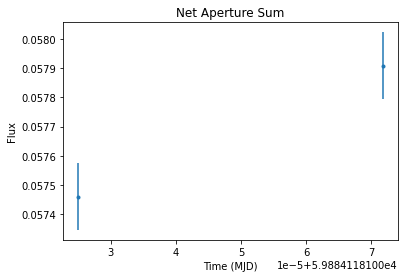

In [14]:
dat = ascii.read('/fenrirdata1/kg_data/pipeline_output/Short_Exposure_Test_NRCA1/modified_test_level3_phot.ecsv') #call the data 

#normalized_net_aperture_sum = dat['net_aperture_sum'].si.value/dat['net_aperture_sum'][0].si.value #normalize the flux values
#std_net_aperture_sum = np.std_net_aperture_sum(normalized_net_aperture_sum[0:20]) #manually calculate the std. (This was helpful prior to finding the outer radii limit which return nan errors.)
#plt.errorbar(dat['MJD'],normalized_flux, yerr=std,fmt='.')

plt.errorbar(dat['MJD'],dat['net_aperture_sum'].value, yerr=dat['net_aperture_sum_err'].value,fmt='.')
plt.title("Net Aperture Sum")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

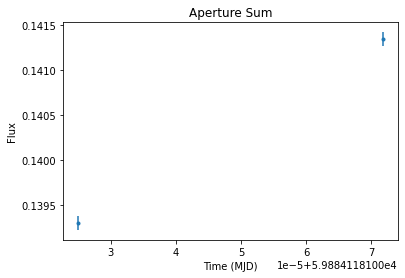

In [15]:
plt.errorbar(dat['MJD'],dat['aperture_sum'].to(u.Jy).value, yerr=dat['aperture_sum_err'].to(u.Jy).value, fmt='.')

plt.title("Aperture Sum")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

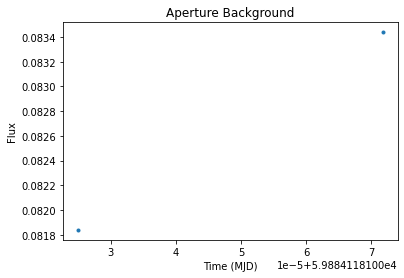

In [16]:
plt.plot(dat['MJD'],dat['aperture_bkg'].to(u.Jy).value,'.')

plt.title("Aperture Background")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

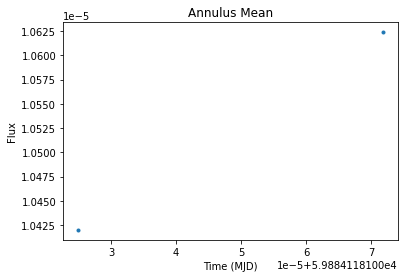

In [17]:
plt.plot(dat['MJD'],dat['annulus_mean'].to(u.Jy).value,'.')

plt.title("Annulus Mean")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux")

Text(0, 0.5, 'Flux')

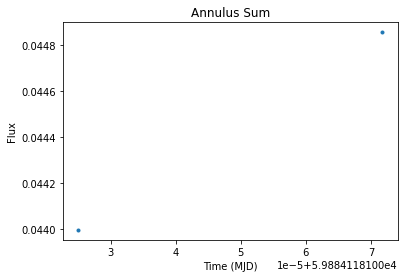

In [18]:
plt.plot(dat['MJD'],dat['annulus_sum'].to(u.Jy).value,'.')

plt.title("Annulus Sum")
plt.xlabel("Time (MJD)")
plt.ylabel("Flux")